In [1]:
import numpy as np
import scipy.spatial.distance as sp_dist
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Set default plot settings
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['savefig.facecolor']='white'

# Question 6

In [74]:
def pca(data, k=2):
    n = len(data)
    d = len(data[0])
    # Centering
    data = np.array(data) - data.mean(axis=0)
    
    # Sample covariance matrix    
    cov = np.cov([data[:,i] for i in xrange(d)])
    
    # Eigenvectors of sample covariance matrix
    evals, evecs = np.linalg.eigh(cov) # eigh() returns them in ascending order of evals
    reduced_dat = np.matmul(data, evecs[:,-k:]) # project on the k evecs with the largest evals
    
    return reduced_dat

def isomap(data, k=10, p=2):
    n = len(data)
    d = len(data[0])
    
    # Distance matrix
    dist = sp_dist.pdist(data)
    dist = sp_dist.squareform(dist)
    
    ## Shortest path distances
    # find k-NN and filter others out as inf
    # NOTE: in the future I should look into scipy.spatial.KDTree()
    for i in xrange(n):
        sorted_idx = np.argsort(dist[i])
        dist[i][sorted_idx[k+1:]] = np.inf
    
    # Floyd-Warshall algo
    for k in xrange(n):
        for i in xrange(n):
            for j in xrange(n):
                if dist[i,j] > (dist[i,k] + dist[k, j]):
                    dist[i,j] = dist[i,k] + dist[k, j]
    
    ## MDS
    P = np.eye(n) - np.ones((n, n))/n # Centering matrix
    G_tilde = -0.5*P.dot(dist**2).dot(P) # Centered "Gram" matrix
    
    # Eigendecomp and get mapped data
    evals, evecs = np.linalg.eig(G_tilde) # not necessarily sorted
    sorted_idx = np.argsort(evals)[-p:] # idx of top p eigenvals 
    Lambda = np.diag(np.sqrt(evals[sorted_idx]))
    Q = evecs[:,sorted_idx]
    reduced_dat = np.matmul(Q, Lambda)
    
    return reduced_dat

def lle(data, k=10, p=2):
    # NOTE: used pseudocode at https://cs.nyu.edu/~roweis/lle/algorithm.html as a reference
    n = len(data)
    d = len(data[0])
    
    # Distance matrix
    dist = sp_dist.pdist(data)
    dist = sp_dist.squareform(dist)
        
    # Find weights
    W = np.zeros((n, n))
    for i in xrange(n):
        # find k-NN, excluding xi itself
        sorted_idx = np.argsort(dist[i])
        
        x_knn = data[sorted_idx[1:k+1]] # nearest neighbour points matrix
        x_knn -= data[i]
        cov = np.matmul(x_knn, x_knn.T) # local covariance (Gram) matrix
        cov = cov + 1.e-3*np.trace(cov)*np.eye(k) # regularize to ensure unique soln
        w = np.linalg.solve(cov, np.ones(k))
        for idx, j in enumerate(sorted_idx[1:k+1]):
            W[i,j] = w[idx]/np.sum(w)
    
    # Find mapped data
    M = np.matmul((np.eye(n)-W).T, (np.eye(n)-W))
    evals, evecs = np.linalg.eigh(M)
    # the [1,p+1] evecs with the smallest evals give the most weight-preserved Ys
    # the evec with eval 0 is not included
    reduced_dat = evecs[:,1:p+1] 
    return reduced_dat

In [3]:
# Load data
data = []
labels = []
with open("3Ddata.txt") as f:
    for line in f:
        data.append([])
        line_split = line.split()
        data[-1] = [float(i) for i in line_split[:3]]
        labels.append(int(line_split[3]))
data = np.array(data)
data = np.array(data) - data.mean(axis=0) # centering

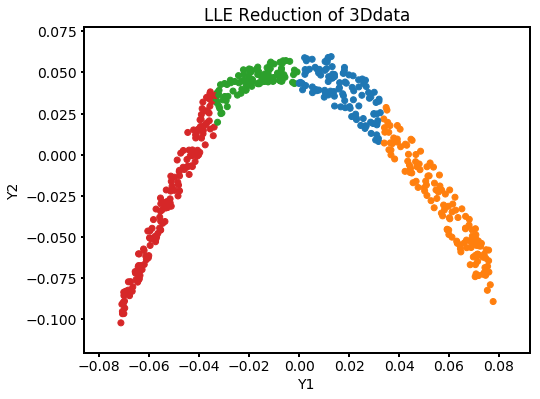

In [5]:
from sklearn import manifold
lle = manifold.LocallyLinearEmbedding(n_neighbors=10)
Y = lle.fit_transform(data)

colors = ['C{}'.format((i-1) % 10) for i in labels]
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(Y[:,0], Y[:,1], c=colors)
plt.xlabel("Y1")
plt.ylabel("Y2")
plt.title("LLE Reduction of 3Ddata")
plt.show()

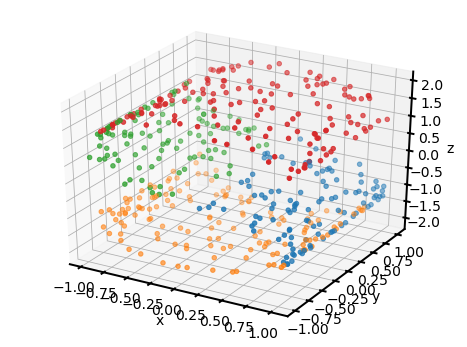

In [42]:
# Plot the centered 3D Data
colors = ['C{}'.format((i-1) % 10) for i in labels]

fig = plt.figure(figsize=(8,6), facecolor='w')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=colors)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

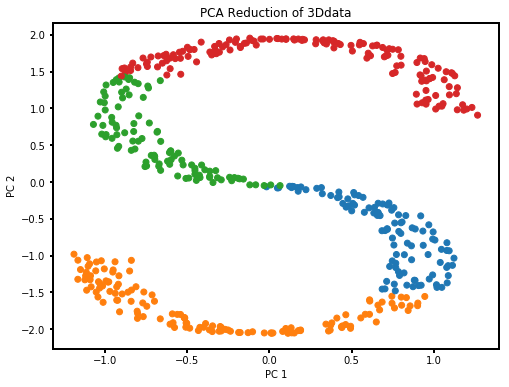

In [45]:
reduced_dat = pca(data)
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(reduced_dat[:,0], reduced_dat[:,1], c=colors)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Reduction of 3Ddata")
plt.show()

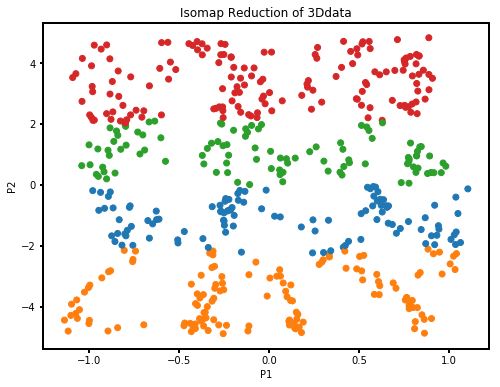

In [92]:
reduced_dat = isomap(data)
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(reduced_dat[:,0], reduced_dat[:,1], c=colors)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("Isomap Reduction of 3Ddata")
plt.show()

We see how PCA retained the "S" shape of the data, since the greatest linearly varying degrees of freedom roughly correspond to the $x$ and $y$ dimensions of $\mathbb{R}^3$. However, the Isomap method was able to unfurl the nonlinear "S" manifold through the objective of perserving the shortest distance paths and thus obtain the greatest varying degrees of freedom along the surface of the "S".  

[ -3.37286477e-17   3.72032266e-09   3.88821988e-07]


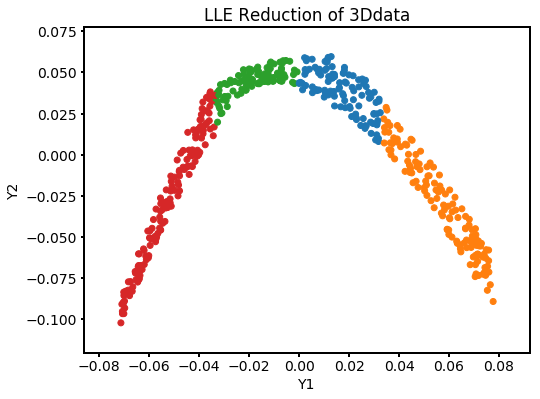

In [73]:
reduced_dat = lle(data)
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(reduced_dat[:,0], reduced_dat[:,1], c=colors)
plt.xlabel("Y1")
plt.ylabel("Y2")
plt.title("LLE Reduction of 3Ddata")
plt.show()

LLE seeks to preserve the local linearly weighted reconstruction of the data points in the lower dimensional map. Due to this locally-based construction, the embedding follows along the manifold similar to the isomap method. The spread in the lower dimensional manifold is tighter than in the isomap however, since we are not directly preserving distances.

# Question 7

In [7]:
class perceptron:
    """Incremental batch training of Perceptron classification"""
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.n = len(data)
        self.d = len(data[0])
        self.w = np.zeros(d)
    
    def train(self):
        for i in xrange(self.n):
            # Prediction
            if np.dot(self.w, self.data[i]) >= 0:
                y = 1
            else:
                y = -1
            
            # Check and adjust:
            if y == -1 and self.labels[i] == 1:
                self.w += self.data[i]
            elif y == 1 and self.labels[i] == -1:
                self.w -= self.data[i]
                
    def predict(self, test_dat):
        # Initialize
        self.n_test = len(test_dat)
        pred_labels = -1*np.ones(self.n_test, dtype="int32")
        
        # Predict and adjust labels
        proj = np.matmul(self.w, test_dat.T)
        pred_labels[np.where(proj >= 0)] = 1
        
        return pred_labels
    
    def test(self, test_dat, test_lbl):
        pred_labels = self.predict(test_dat)
        
        # Count mistakes and return as fraction
        mistakes = np.sum(pred_labels != test_lbl)
        
        return float(mistakes)/self.n_test    

In [8]:
# Load data
train_dat = np.loadtxt("train35.digits")
train_labels = np.loadtxt("train35.labels", dtype="int32")
n = len(train_dat)
d = len(train_dat[0])

n_epoch = 20
cv_num = 5
train_error = np.zeros((n_epoch+1, cv_num))
valid_error = np.zeros((n_epoch+1, cv_num))

for j in xrange(cv_num):
    # Extract subsets for cross-validaton
    t_mask = np.ones(n, dtype=bool)
    t_mask[j::cv_num] = 0
    v_mask = np.zeros(n, dtype=bool)
    v_mask[j::cv_num] = 1

    train_subset = train_dat[t_mask] 
    valid_subset = train_dat[v_mask]
    
    # Initialize Perceptron
    percep = perceptron(train_subset, train_labels[t_mask])
    train_error[0, j] = percep.test(train_subset, train_labels[t_mask])
    valid_error[0, j] = percep.test(valid_subset, train_labels[v_mask])
    for i in xrange(n_epoch):
        percep.train() # train on all the data
        train_error[i+1, j] = percep.test(train_subset, train_labels[t_mask])
        valid_error[i+1, j] = percep.test(valid_subset, train_labels[v_mask])   

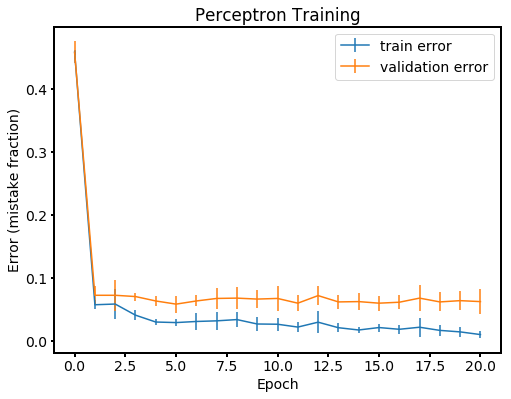

In [9]:
fig0 = plt.figure(figsize=(8,6), facecolor='w')
plt.errorbar(range(n_epoch+1), np.mean(train_error, axis=1), yerr=np.std(train_error, axis=1), label="train error")
plt.errorbar(range(n_epoch+1), np.mean(valid_error, axis=1), yerr=np.std(valid_error, axis=1), label="validation error")
plt.xlabel("Epoch")
plt.ylabel("Error (mistake fraction)")
plt.title("Perceptron Training")
plt.legend(loc='best')
plt.show()

From 5-fold cross validation of the training set, we see that the validation error is minimized at M=5. Now we train on the entire set for that many epochs and make a prediction for the test set.

In [11]:
# Load test data
test_dat = np.loadtxt("test35.digits")

# Initialize Perceptron
percep = perceptron(train_dat, train_labels)
for i in xrange(5):
    percep.train() # train on all the data

# Predict
pred_labels = percep.predict(test_dat)
np.savetxt("test35.predictions", pred_labels, fmt='%d')